<a href="https://colab.research.google.com/github/juanpalominoh/Fundamentos-de-Econometria/blob/main/Tema_7_Multicolinealidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multicolinealidad**

In [ ]:
# Instalar paquetes
install.packages("readstata13")
install.packages("ggplot2")
install.packages("memisc")
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Llamar librerias
library(readstata13)
library(dplyr)
library(ggplot2)
library(memisc)

## **Multicolinealidad Perfecta**

Descargar la Encuesta Nacional de Empresas 2018 del siguiente link: https://ogeiee.produce.gob.pe/index.php/en/shortcode/normatividad-metodologia-oee/encuesta-nacional-de-empresas 

In [ ]:
system("gdown --id 1V0ghySxPRs6sgtfoGctv-zu_Qmuc7LN1")

In [ ]:
# Importar bases de datos
data <- read.dta13("/content/ENE2018_innominada.dta", convert.factors = F) 

In [ ]:
names(data)

In [ ]:
# Seleccionar variables y filtrar solo encuestas completas e incompletas
data <- data %>% 
  dplyr::select(id_empresa, CCDD, NOMBRECCDD,      
         CIIU_CD, CIIU_DESC, P25, P27, P28, P29, C3P301A_T2,
         C3P302A_1, C3P302A_2, C3P302A_3, C3P302A_4, C3P302A_5, C3P302A_6, C3P302A_7, C3P302A_8,
         C9P912_7, C9P914_T5, RESFIN) %>%
  filter(RESFIN==1 | RESFIN==2)

In [ ]:
# Renombrar variables
data <- data %>%
    rename(P25=tam_emp, P27=sexo, P28=edad, P29=niv_educ,
           C3P302A_8=trabajadores, C9P912_7=vab, C9P914_T5=capital)

In [ ]:
# Crear suma de variables
data <- data %>%
  rowwise %>%
  mutate(trabaj_calif=sum(C3P302A_1,C3P302A_2,C3P302A_3, na.rm=TRUE),
         trabaj_nocalif = sum(C3P302A_4, C3P302A_5, C3P302A_6, C3P302A_7, na.rm=TRUE)
         )

In [ ]:
# Crear logaritmos
data <- data %>% 
  mutate(ln_vab=log10(vab),
         ln_k=log10(capital),
         ln_tcalif=log10(trabaj_calif),
         ln_tnocalif=log10(trabaj_nocalif),
  )

In [ ]:
# Reemplazar NaN & Inf con NA
data[is.na(data) | data=="Inf" | data=="-Inf"] = NA

In [ ]:
# Crear variable de logaritmo de trabajadores total
data <- data %>%
  rowwise %>%
  mutate(ln_trab=sum(ln_tcalif, ln_tnocalif, na.rm=TRUE))

In [ ]:
# Reemplazar NA de ln_trab si existen missing en trabajadores calificados y no calificados a la ve
data$ln_trab[is.na(data$ln_tcalif) & is.na(data$ln_tnocalif)] <- NA

In [ ]:
head(data)

id_empresa,CCDD,NOMBRECCDD,CIIU_CD,CIIU_DESC,tam_emp,sexo,edad,niv_educ,C3P301A_T2,⋯,vab,capital,RESFIN,trabaj_calif,trabaj_nocalif,ln_vab,ln_k,ln_tcalif,ln_tnocalif,ln_trab
<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,16,LORETO,5022,TRANSPORTE DE CARGA POR VÍAS DE NAVEGACIÓN INTERIORES,1,1,55,6,4,⋯,8500,223000,1,1,3,3.929419,5.348305,0.0000000,0.4771213,0.4771213
4,25,UCAYALI,5022,TRANSPORTE DE CARGA POR VÍAS DE NAVEGACIÓN INTERIORES,1,1,65,6,5,⋯,170000,8775000,1,0,5,5.230449,6.943247,NA,0.6989700,0.6989700
7,16,LORETO,3100,FABRICACIÓN DE MUEBLES,1,1,60,10,1,⋯,16020,60000,1,0,0,4.204663,4.778151,NA,NA,NA
10,13,LA LIBERTAD,9609,OTRAS ACTIVIDADES DE SERVICIOS PERSONALES N.C.P.,1,2,51,10,6,⋯,245600,2400,1,6,0,5.390228,3.380211,0.7781513,NA,0.7781513
11,25,UCAYALI,4520,MANTENIMIENTO Y REPARACIÓN DE VEHÍCULOS AUTOMOTORES,1,1,64,6,2,⋯,149700,34800,1,1,1,5.175222,4.541579,0.0000000,0.0000000,0.0000000
13,25,UCAYALI,5022,TRANSPORTE DE CARGA POR VÍAS DE NAVEGACIÓN INTERIORES,1,1,49,6,4,⋯,350000,975000,1,0,4,5.544068,5.989005,NA,0.6020600,0.6020600


In [ ]:
# Regresión 
ols_1 <- lm(ln_vab ~ ln_tcalif + ln_tnocalif + ln_trab + ln_k, data=data)
summary(ols_1)


Call:
lm(formula = ln_vab ~ ln_tcalif + ln_tnocalif + ln_trab + ln_k, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3690 -0.3297 -0.0208  0.3134  3.1406 

Coefficients: (1 not defined because of singularities)
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.226190   0.039735   81.19   <2e-16 ***
ln_tcalif   0.449012   0.014273   31.46   <2e-16 ***
ln_tnocalif 0.308325   0.014239   21.65   <2e-16 ***
ln_trab           NA         NA      NA       NA    
ln_k        0.386822   0.008254   46.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5573 on 6019 degrees of freedom
  (6391 observations deleted due to missingness)
Multiple R-squared:  0.7705,	Adjusted R-squared:  0.7704 
F-statistic:  6737 on 3 and 6019 DF,  p-value: < 2.2e-16


*¿Qué pasa con el coeficiente de ln_trab?*

## **Multicolinealidad Imperfecta**

La base de datos que se usa es:

*   **Base de datos de bienestar en América Latina**: contiene variables sobre los Estados de bienestar en todos los países de América Latina y el Caribe entre 1960 y 2014.

In [ ]:
# Instalar paquetes y llamar librerias
install.packages("tidyverse")
library(tidyverse)

install.packages("remotes")
library(remotes)

install_github("arcruz0/paqueteadp")
library(paqueteadp)

install.packages("skimr")
library(skimr)

install.packages("ggcorrplot")
library(ggcorrplot)

install.packages("car")
library(car)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




tibble  (3.1.7 -> 3.1.8 ) [CRAN]
openssl (2.0.2 -> 2.0.3 ) [CRAN]
texreg  (NA    -> 1.38.6) [CRAN]


Installing 3 packages: tibble, openssl, texreg

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



* checking for file ‘/tmp/Rtmpcx8NI7/remotes373433e465/arcruz0-paqueteadp-44a8c77/DESCRIPTION’ ... OK
* preparing ‘paqueteadp’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘paqueteadp/data/latinobarometro.rda’
    ‘paqueteadp/data/quiebre_democracia.rda’
* building ‘paqueteadp_1.0.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Importar base de datos
data("bienestar")
bienestar

pais,codigo_pais,anio,poblacion,gini,dualismo_sectorial,pib,inversion_extranjera,diversidad_etnica,tipo_regimen,gasto_educ,gasto_salud,gasto_segsocial,bal_legislativo,represion
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Argentina,ARG,1970,29.34501,36.1,NA,7809.74,0.28422430,0,2,1.0,0.3,5.0,0.00000000,1.0
Argentina,ARG,1971,29.22258,NA,NA,7968.57,0.37746448,0,2,0.6,0.4,4.6,0.00000000,1.0
Argentina,ARG,1972,29.12433,35.3,NA,7955.78,0.20648950,0,2,1.2,0.4,3.9,0.00000000,1.0
Argentina,ARG,1973,29.07185,NA,NA,8025.39,0.19079248,0,2,1.6,0.5,4.6,-0.04938280,0.5
Argentina,ARG,1974,29.09083,32.0,NA,8364.00,0.02473881,0,3,1.4,0.3,5.4,-0.04938280,0.0
Argentina,ARG,1975,29.19448,36.1,NA,8164.20,0.10600960,0,3,1.8,0.4,4.7,-0.04938280,0.0
Argentina,ARG,1976,29.38859,35.2,NA,8176.59,0.47817548,0,2,0.8,0.4,3.6,0.00000000,1.0
Argentina,ARG,1977,29.65610,40.3,NA,8656.89,0.25360596,0,2,1.4,0.8,3.7,0.00000000,1.0
Argentina,ARG,1978,29.95924,43.4,NA,8273.89,0.43041950,0,2,1.6,0.6,5.2,0.00000000,1.0


Utilizaremos el documento de Huber et al. (2006) como ejemplo para el análisis. En este artículo, se estiman los determinantes de la desigualdad en América Latina y el Caribe. Así, la variable dependiente que nos interesa explicar es la desigualdad de ingresos en los países de América Latina y el Caribe, operada de acuerdo al Índice de Gini (gini). Las variables independientes que incorporaremos al modelo son las siguientes:
*   Dualismo sectorial (se refiere a la coexistencia de un sector tradicional de baja productividad y un sector moderno de alta productividad) - **dualismo_sectorial**
*   PBI del país - **pib**
*   Inversión Extranjera Directa (ingresos netos como % del PIB) - **inversion_extranjera**
*   Diversidad étnica (variable dummy codificada como 1 cuando al menos el 20% pero no más allá del 80% de la población es étnicamente diversa) - **diversidad_etnica**
*   Democracia (tipo de régimen) - **tipo_regimen**
*   Gasto en educación (como porcentaje del PIB) - **gasto_educ**
*   Gasto en salud (como porcentaje del PIB) - **gasto_salud**
*   Gasto de seguridad social (como porcentaje del PIB) - **gasto_sectorial**
*   Equilibrio legislativo - **bal_legislativo**

Estimaremos un modelo de población en el que la desigualdad social (gini) es una función lineal del gasto en educación como porcentaje del PIB (gasto_educ), de la inversión extranjera directa (inversion_extranjera), del gasto en salud como porcentaje del PIB (gasto_salud), del gasto en seguridad social como porcentaje del PIB. (gasto_segsocial), de la población joven (poblacion), del dualismo estructural de la economía (s_dualismo), de la división étnica (diversidad_etnica), del PIB real per cápita (pib), del tipo de régimen (tipo_regimen), y del equilibrio entre los poderes del Estado (bal_legislativo).

In [ ]:
skimr::skim(bienestar)

── Data Summary ────────────────────────
                           Values   
Name                       bienestar
Number of rows             1074     
Number of columns          15       
_______________________             
Column type frequency:              
  character                2        
  numeric                  13       
________________________            
Group variables            None     

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 pais                  0             1   4  20     0       25          0
2 codigo_pais           0             1   3   3     0       25          0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable        n_missing complete_rate       mean       sd       p0
 1 anio                         0         1     1991.        12.4   1970    
 2 poblacion                  129         0.880  

Warning message in is.null(text_repr) || nchar(text_repr) == 0L:
“'length(x) = 2 > 1' in coercion to 'logical(1)'”


Antes de estimar el modelo, filtraremos la base de datos eliminando todos los casos con valores perdidos (NA). Aquí, por motivos prácticos, sólo consideraremos aquellos casos (país-año) que estén completos en todas las variables de nuestro modelo, eliminando los valores perdidos.

In [ ]:
bienestar_no_na <- bienestar %>% 
  drop_na(gini, gasto_educ , inversion_extranjera , gasto_salud , gasto_segsocial , poblacion, 
          dualismo_sectorial, diversidad_etnica, pib, tipo_regimen, bal_legislativo)

In [ ]:
options(scipen=999)

In [ ]:
model_1 <- lm(gini ~ 1 + gasto_educ + inversion_extranjera + gasto_salud + gasto_segsocial + 
                poblacion + dualismo_sectorial + diversidad_etnica + pib + 
                factor(tipo_regimen) + bal_legislativo,
              data = bienestar_no_na)

In [ ]:
summary(model_1)


Call:
lm(formula = gini ~ 1 + gasto_educ + inversion_extranjera + gasto_salud + 
    gasto_segsocial + poblacion + dualismo_sectorial + diversidad_etnica + 
    pib + factor(tipo_regimen) + bal_legislativo, data = bienestar_no_na)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.6812  -2.4890  -0.2743   2.4589  17.3668 

Coefficients:
                         Estimate  Std. Error t value             Pr(>|t|)    
(Intercept)            85.9362071   8.7323224   9.841 < 0.0000000000000002 ***
gasto_educ              1.5850445   0.4522343   3.505             0.000598 ***
inversion_extranjera    0.2382316   0.1817482   1.311             0.191884    
gasto_salud            -0.8301989   0.2598473  -3.195             0.001697 ** 
gasto_segsocial        -0.8272786   0.2022655  -4.090          0.000069300 ***
poblacion              -0.9290193   0.1697788  -5.472          0.000000177 ***
dualismo_sectorial     -0.1704407   0.0343966  -4.955          0.000001885 ***
diversidad_etnica

In [ ]:
table_1 <- mtable("Model 1" = model_1,
            summary.stats = c("N", "R-squared", "F", "p"),
            coef.style = "default", 
            digits=3)

(table_1 <- relabel(table_1,
          "(Intercept)" = "Constante",
          gasto_educ = "Gasto en educación",
          inversion_extranjera = "IED",
          gasto_salud = "Gasto en salud",
          gasto_segsocial="Gasto en seg. social",
          poblacion="Población jóven",
          dualismo_sectorial="Dualismo en economía",
          diversidad_etnica="División étnica", 
          pib="PBI pc",
          bal_legislativo="Balance entre poderes"
          )
)
# "Reg. democrático", "Reg. mixto", "Reg. autoritario"

Warning message in checkLaTeXcape(leaders, "row leaders"):
“Unescaped TeX special in row leaders”


Calls:
Model 1: lm(formula = gini ~ 1 + gasto_educ + inversion_extranjera + gasto_salud + 
    gasto_segsocial + poblacion + dualismo_sectorial + diversidad_etnica + 
    pib + factor(tipo_regimen) + bal_legislativo, data = bienestar_no_na)

=========================================
  Constante                   85.936***  
                              (8.732)    
  Gasto en educación           1.585***  
                              (0.452)    
  IED                          0.238     
                              (0.182)    
  Gasto en salud              -0.830**   
                              (0.260)    
  Gasto en seg. social        -0.827***  
                              (0.202)    
  Población jóven             -0.929***  
                              (0.170)    
  Dualismo en economía        -0.170***  
                              (0.034)    
  División étnica              3.680***  
                              (1.038)    
  PBI pc                      -0.000**   
                              (0.000)    
  factor(tipo_regimen): 2/1   -2.294     
                              (4.751)    
  factor(tipo_regimen): 3/1   -2.899     
                              (4.702)    
  factor(tipo_regimen): 4/1   -5.136     
                              (4.620)    
  Balance entre poderes      -10.402***  
                              (2.216)    
-----------------------------------------
  N                          167         
  R-squared                    0.592     
  F                           18.593     
  p                            0.000     
=========================================
  Significance: *** = p < 0.001;   
                ** = p < 0.01;   
                * = p < 0.05

Interpretación: cuando el gasto en educación aumenta en una unidad, la desigualdad aumenta en un promedio de 1,59 puntos porcentuales, manteniendo constantes todos los demás factores.

Para evaluar la multicolinealidad, el primer paso es observar la matriz de correlación de las variables de nuestro modelo

In [ ]:
install.packages("corrplot")
library(corrplot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.92 loaded



In [ ]:
corr_selected <- bienestar %>% 
  dplyr::select(gini, gasto_educ, dualismo_sectorial, inversion_extranjera, pib, 
         diversidad_etnica, tipo_regimen, gasto_salud, gasto_segsocial,
         bal_legislativo, poblacion) %>% 
  # calcular la matriz de correlación y redondear a un decimal
  cor(use = "pairwise") %>% 
  round(1)

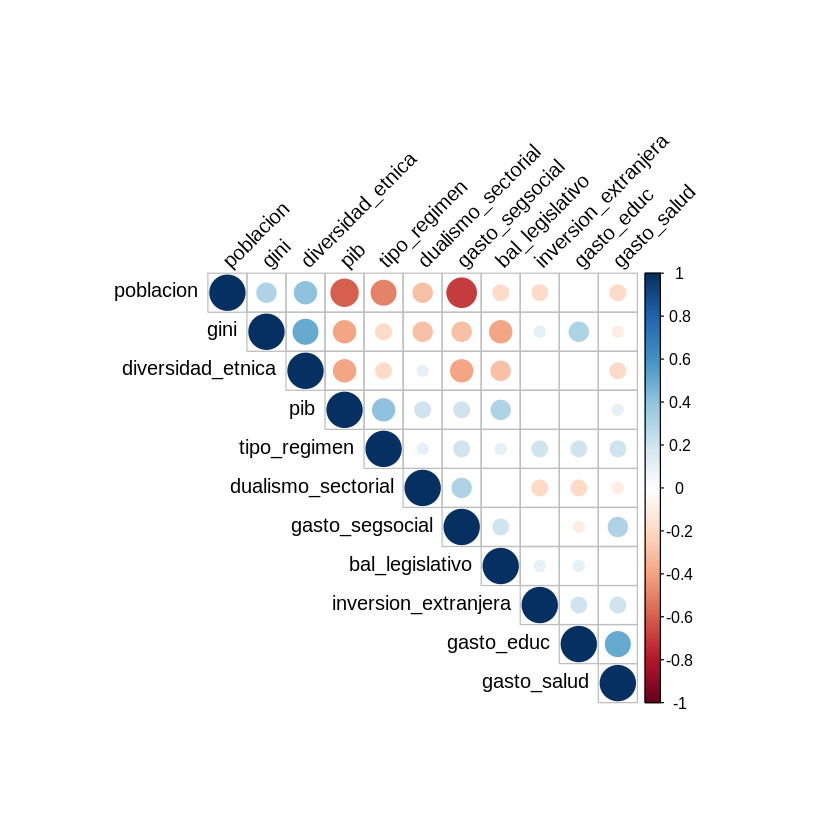

In [ ]:
corrplot(corr_selected, type="upper", order="hclust", tl.col="black", tl.srt=45)

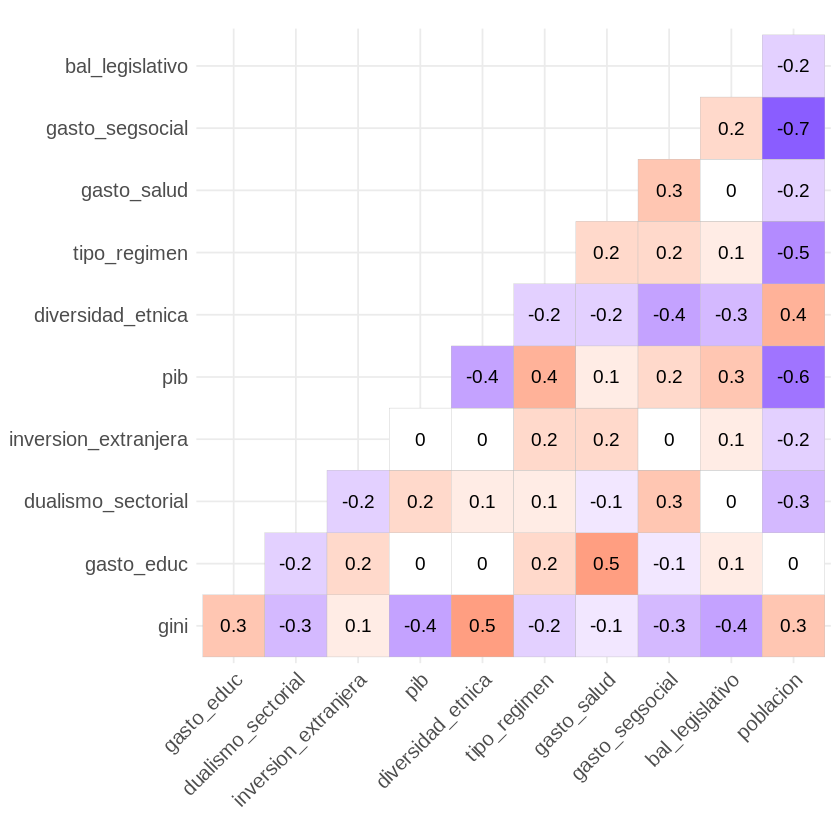

In [ ]:
ggcorrplot(corr_selected, type = "lower", lab = T, show.legend = F)

Vemos que algunas de nuestras variables tienen fuertes correlaciones, como el gasto en seguridad social (**gasto_segsocial**) y la población (**poblacion**), que tiene una correlación negativa de 0,7.

### **Factor de Inflación de la Varianza (VIF)**


En cualquier caso, para detectar si la multicolinealidad es un problema, es necesario realizar un test de VIF (variance inflation factor), porque mirar los pares de correlaciones no nos ayuda a establecer si más de dos variables tienen una correlación lineal. Lo que el test VIF revela es cuánto “crecen” los errores de los coeficientes cuando el resto de las variables están presentes (cuánto aumenta la varianza del error).

El Factor de Inflación de la Varianza se define así:
\begin{gather*}
VIF = \frac{1}{1-R^{2}_{z}}
\end{gather*}
siendo $R^{2}_{z}$ el coeficiente de determinación de la regresión auxiliar de la varaible $X_{k}$ sobre el resto de las variables explicativas. El VIF toma valores entre 1 e $\infty$.

El VIF para cada término del modelo mide el efecto combinado que tienen las dependencias entre los regresores sobre la varianza de ese término. Si hay uno o más VIF grandes, hay multicolinealidad. La experiencia indica que si cualquiera de los VIF es mayor que 5 o 10, es indicio de que los coeficientes asociados de regresión están mal estimados debido a la multicolinealidad.

In [ ]:
vif(model_2)

,GVIF,Df,GVIF^(1/(2*Df))
gasto_educ,1.831416,1,1.353298
inversion_extranjera,1.473459,1,1.213861
gasto_salud,1.753385,1,1.324155
gasto_segsocial,4.842801,1,2.200637
poblacion,5.019055,1,2.240325
dualismo_sectorial,1.216700,1,1.103041
diversidad_etnica,1.944754,1,1.394544
pib,2.450633,1,1.565450
factor(tipo_regimen),2.653868,3,1.176648
bal_legislativo,1.743851,1,1.320550


A continuación, hacemos una consulta sobre si el VIF para cada variable es inferior a 10. Si es superior a 10, significa que la varianza es alta. Por lo tanto, hay problemas de multicolinealidad.

In [ ]:
vif(model_2) > 10

,GVIF,Df,GVIF^(1/(2*Df))
gasto_educ,FALSE,FALSE,FALSE
inversion_extranjera,FALSE,FALSE,FALSE
gasto_salud,FALSE,FALSE,FALSE
gasto_segsocial,FALSE,FALSE,FALSE
poblacion,FALSE,FALSE,FALSE
dualismo_sectorial,FALSE,FALSE,FALSE
diversidad_etnica,FALSE,FALSE,FALSE
pib,FALSE,FALSE,FALSE
factor(tipo_regimen),FALSE,FALSE,FALSE
bal_legislativo,FALSE,FALSE,FALSE


In [ ]:
install.packages("mctest")
library(mctest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



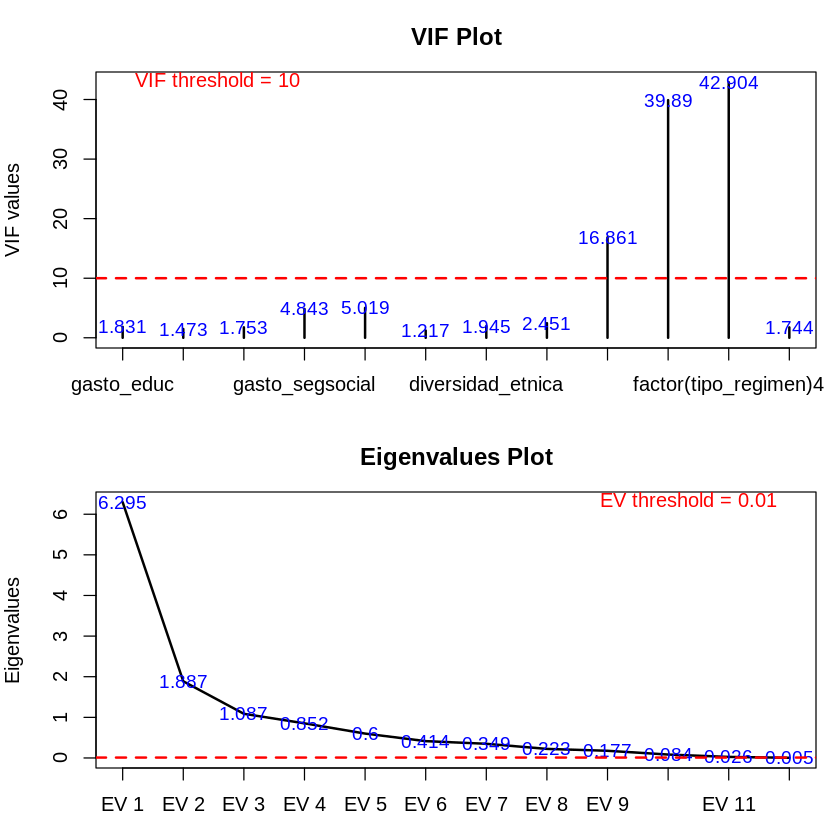

In [ ]:
#Gráfica
mc.plot(model_2, vif = 10)